# Wykrywanie anomalii - tutorial 
## Wstęp
Badając dane często możemy spotkać sie z elementami zbioru danych które różnią się od ogółu danych. Takie przypadki mogą mieć znaczący i zróżnicowany wpływ na wnioski jakie wynosimy z danych. Tego typu zjawsiko moze mieć także różne przyczyny od związanych z rzeczywistym rozkładem badanego zjawiska po błędy ludzkie czy też maszynowe zwiazane z odczytywnaniem czy przekształcaniem danych. Badanie tego typu zjawisk nosi nazwę **wykrywywania anomalii** (ang. *outlier detection*)

Przykładowymi outlierami mogą być na przykład hity, czyli stylokolory sprzedające się dużo szybciej od innych. Innym przykładem outlierów mogą być na przykład podjerzane transakcje kartami kredytowymi - nadanie tego typu zdarzeń nosi angielską nazwę *fraud detection*
<div class="alert alert-block alert-success">
<b>Definicja</b> 
    
Objekt w zbiorze danych nazywamy obserwacją odstającą (outlierem) jeżeli spełnia nastepujące warunki 
    <li>Odchyla się od normalnego/znanego zachowania danych</li>
    <li>Przyjmuje wartości dalekie od oczekiwanych bądź też średnich</li>
    <li>Jego charakterystyka nie jest połączona z, ani podobna do, żadnego innego objektu</li>
</div>

Możemy więc powiedzieć, że outlier charakteryzuje sie pewnymi niezwyczajnymi cechami w zbiorze danych. Wspomniana niezwyczajność nie ma charakteru wartościujacego, ponieważ anomalie mogą być zarówno zjawiskami korzystnymi jak i nie. Anomalią może być bardzo dobrze sprzedający się stylokolor, moze też nią być słabo sprzedający salon.

<div class="alert alert-block alert-info">
<b>Info</b> 

To czym jest, a czym nie jest wartość odstająca nie ma ścisłej matematycznej definicji. 
To co jest albo nie outlierem w analizie musi opierać się na biznesowym zrozumieniu danych i zadania przed którym stoimy.
</div>

Spróbujmy złapać intuicję na temat tego czym są elementy odstające za pomoca prostego syntetycznego przykładu. Na początku zaimportujmy potrzebne pakiety.

In [1]:
# importy
import numpy as np

import plotly.graph_objects as go # pakiet plotly służy do interaktywnych wizualizacji

Wygenerujmy losowe dane 

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
Nie polecam używania funkcji <i>np.random.seed</i> do generowania liczb losowych. 
Ten sposób ustalenia ziarna spowoduje że każde wywołanie tej samej funkcji losującej zwróci identyczny wynik.
Przy wielokrotnym wywoływaniu w tym samym skrypcie funkcji losującej to nie jest zachowanie którego oczekujemy. 
Użycie default_rng zapewni powtarzalne wyniki, a pozwoli uniknąć wspomnianego problemu.
</div>

In [2]:
rng = np.random.default_rng(42) # ustawiamy ziarno w celu uzyskanie reprodukowalności

In [3]:
mu, sigma = 0, .05 # ustalmy wartość oczekiwana i odchylenie standardowe dla rozkładu normalnego
low, high = .35, .65 # ustalamy minmum i maskimum dla rozkładu jednostajnego

x_noise = rng.normal(mu, sigma, 50) # losujemy 50 przykładów szumu
y_noise = rng.normal(mu, sigma, 50) # losujemy 50 przykładów szumu
x_line = rng.uniform(low, high, 50) # losujemy punkty dla prostej y = x
y_line = x_line
x_data = x_line + x_noise # dodajemy szum do prostej
y_data = y_line + y_noise 
outlier_x = [.95] # dodajemy outliera
outlier_y = [.1]

Tworzymy wykres z wygenerowanymi danymi

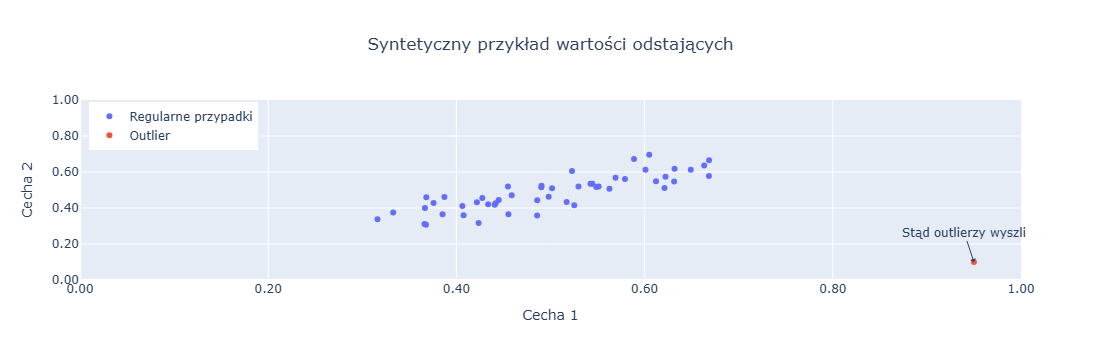

In [4]:
fig = go.Figure(data=[go.Scatter(x=x_data, y=y_data, mode='markers', name='Regularne przypadki'),
                      go.Scatter(
    x=outlier_x, y=outlier_y, mode='markers', name='Outlier')],
    layout=go.Layout(xaxis={'range': [0, 1], 'title': 'Cecha 1', 'tickformat': ',.2f'},
                     yaxis={
        'range': [0, 1], 'title': 'Cecha 2', 'tickformat': ',.2f'},
    title={
        'text': 'Syntetyczny przykład wartości odstających', 'x': 0.5},
    legend={'yanchor': 'top',
            'y': 0.99,
            'xanchor': 'left',
            'x': 0.01
            })) # tworzymy wykres punktowy wygenerowanych punktów
fig.add_annotation(x=.95, y=.1,
                   text='Stąd outlierzy wyszli',
                   showarrow=True,
                   arrowhead=1) # dodajemy adnotacje
fig.show() # wyświetlamy wykres

Na wykresie widzimy, że punkt zaznaczony na czerwono wyraźnie odstaje od punktów w kolorze niebieskim. Ten właśnie punkt jest wartością odstajacą. Takich wartości czesto może byc więcej niż 1. Na przykład gdy mówimy o sprzedaży stylokolorów, kilka z nich może sprzedawać się znacznie lepiej niż reszta stylokolorów i przez to być wartością odstającą.

Po zdefiniowaniu co rozumiemy jako elementy odstające, przejdziemy do sprawdzenia w jaki sposób możemy takie obiekty odnaleźć w badanych danych. Przyjrzyjmy się zatem  więc sposobom odnajdywania outlierów ze wzgledu na typy.

## Wykres pudełkowy
Pierwszym sposobem odnajdywania outlierów z którym się zapoznamy jest wykres pudełkowy (ang. *box-and-whisker plot*). Pozwala ona zwizualizowac jednocześnie statystyki opisowe danych, które badamy jak i wartości odstające, będąc wygodnym narzedziem do badania rozkładu danych które nas interesują. Do stworzenia wykresów wykorzystamy wygenerowane uprzednio syntetyczne dane.

In [5]:
import pandas as pd
df = pd.DataFrame({'Cecha 1': np.concatenate((outlier_x, x_data)),
                   'Cecha 2': np.concatenate((outlier_y, y_data))})
df_melted = df.melt(var_name='Cecha', value_name= 'Wartość')  # przygotowywyujemy dane do wykresu

Na wykresie poniżej widzimy przykłady wykresów pudełkowych stworzonych na wygenerowanych przez nas danych. Zwrócmy uwagę na niebieskie i czerwone pudełka, od których pochodzi nazwa wykresu. Rozciągaja się one od wartości pierwszego kwartyla oznaczanej przez $Q_{1}$ do wartości trzeciego kwartyla $Q_{3}$. Linia przecinająca pudełko równolegle do osi x oznacza medianę wartości zmiennej w danych.

Następnie widzimy wysuwające się w góre i dół "wąsy". Górny wąs zaczyna sie od wartości 3 kwartyla kończąć się na najwiekszej wartości cechy mieszącej się w przedziale $(Q_{3},Q_{3}+ 1.5(Q_{3} - Q_{1})] $. Odpowiednio dolny wąs ciągnie się od najmniejszej wartości mieszczącej się w przedziale $[Q_{1}- 1.5(Q_{3} - Q_{1}), Q_{1}) $ do wartości pierwszego kwartyla.

Oprócz wspomnianych elementów na wykresie pudełkowym dla obu z cech widzimy po jednym punkcie nie mieszczącym się w zakresie wyznaczanym przez końce górnego i dolnego wiersza. Dla cechy 1 (niebieski wykres) jest to wartość $0.95$, z kolei dla cechy 2 (czerwony wykres) jest to wartość $0.1$. Te punkty to wartości odstające.

In [6]:
import plotly.express as px
fig = px.box(df_melted, y='Wartość', facet_col='Cecha', color='Cecha',
             boxmode='overlay', )  # tworzymy wykres pudełkowy
fig.add_annotation(x=.25, y=.498,
                   text='Mediana',
                   showarrow=True,
                   ax=50,
                   ay=-25,
                   arrowhead=1)  # dodajemy adnotacje
fig.add_annotation(x=.25, y=.586,
                   text='Trzeci kwartyl',
                   showarrow=True,
                   ax=50,
                   ay=-25,
                   arrowhead=1)  
fig.add_annotation(x=.25, y=.424,
                   text='Pierwszy kwartyl',
                   showarrow=True,
                   ax=50,
                   ay=25,
                   arrowhead=1)  
fig.add_annotation(x=.125, y=.668,
                   text='Górny wąs',
                   showarrow=True,
                   ax=50,
                   ay=-25,
                   arrowhead=1)  
fig.add_annotation(x=.125, y=.316,
                   text='Dolny wąs',
                   showarrow=True,
                   ax=50,
                   ay=25,
                   arrowhead=1)  
fig.add_annotation(x=0, y=.95,
                   text='Wartość odstająca',
                   showarrow=True,
                   ax=50,
                   ay=25,
                   arrowhead=1)  

fig.show() # wyświetlamy wykres

Wykres pudełkowy pozwala nam w prosty sposób przeanalizować dane i poznać statystyki opisowe takie jak mediana czy wartości innych kwartyli które charakteryzują badane dane w jasny i łatwy do zrozumienia sposób. Istnieją także inne sposoby wykrywania anomalii niż przedstawiony tutaj tradycyjny wykres pudełkowy takie jak na przykład wcięty wykres pudełkowy (ang. *notched box plot*), które mając wcięcia przy medianie obrazując jej przedział ufności.

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
   Wykresy pudełkowe nie są pozbawione wad jeśli chodzi o wyznaczanie wartości odstajacych. Naczelnym problemem jest brak możliwości uwzględnienia relacji między badanymi cechami. Jak widzimy na wykresie każdy wykres reprezentuje wartości tylko dla jednej zmiennej. Jest to poważne uproszczenie. Kolejna wadą wykresów pudełkowych jest brak elastyczności przy ustalaniu czym w naszym zadaniu jest wartość odstająca, co utrudnia uwzględnienie naszych założeń biznesowych.
</div>

## Las izolacji
Las izolacji jest metodą wykorzystująca uczenie zespołowe oraz drzewa decyzyjne do wykrywania wartości odstających, polegającą na użyciu zespołu wielu drzew izolujących.

### Czym jest las izolacji

Metoda lasu izolującego wykorzystuje dwie ilościowe własności anomalii, mianowicie
- Niewielką ilość : anomalie stanowią mniejszość przypadków
- Odmienność: anomalie mają wartości atrybutów diametralnie różne od normalnych przypadków

Te właśnie cechy sprawiaja, że elementy o wartościach odstających są podatne na izolację. W celu wyizolowania elementu, rekurencyjnie dzielimy przypadki aż do wyizolowania ostatniego elementu. Podziały sa generowane przez losowy wybór atrybutu i losowy wybór wartości podziału mieszczącej się pomiędzy najmniejszą i największą wartością wybraną atrybutu. Ponieważ rekurencyjne podziały mogę być reprezentowane za pomocą struktury drzewa, ilość partycji potrzebnych od izolacji punktu jest odpowiednia długości ścieżki od korzenia drzewa do jego końcowego wierzchołka. 

<!-- ![1_a.png](attachment:1_a.png) -->
<!-- <img src="1_a.png" width=500 height=500 /> 
 -->
![media](1_a.png)


Intuicyjnie dla anomalii ścięzki będą krótsze niz dla normalnych elementów, ponieważ elementy odstające są łatwiejsze do odzielenia od elementów normalnych, tak jak widzimy to na rysunku powyżej. Element oznaczony na czerwono odróżniający jest dość łatwy to oddzielenia, to jest przeprowadzenia takich cięć aby został jedynym w węźle. Dla elementu zaznaczonego na zielono znajdującego się wśród innych elemntów jest to trudniejsze.

Zdefiniujmy zatem drzewo izolujące.

<div class="alert alert-block alert-success">

<b>Definicja</b> 
    
Niech $X = \{x_{1},x_{2},..,x_{n}\}$ będzie zbiorem d wymiarowych punktów i niech $X' \subset X$. Drzewo izolacji będzie zdefiniowane przez następujące własności.
<ol>
<li>

 Dla każdego węzła $T$ w drzewie, T jest zewnętrznym węzłem (liściem) bez dzieci albo wewnętrznym węzłem z dokładnie dwoma węzłami potomnymi $T_{l}$ i $T_{r}$ oraz dokładnie jednym <i>testem</i></li>
    <li><i>Test</i> składa się z atrybutu $q$ i wartość podziału $p$, takiej że test $q<p$ dzieli punkty na $T_{l}$ i $T_{r}$ 
    
</li>
</ol>
</div>

Mając naszą próbkę danych $X$ dzielimy ją rekurencyjnie  losowo wybierając atrybut $q$ i wartość podziału $p$ dopóki nie zajdzie jedno z natępujących: 
- węzeł będzie miał tylko jeden element
- wszystkie elementy w węźle będą miały taką samą wartość


Przy uczeniu poszczególnych drzew w lesie stosujemy próbkowanie, uczymy drzewo na losowo wybranym podzbiorze danych.

Do oznaczenia, które elementy zbioru są anomaliami potrzebujemy jeszcze miary odstawania. Dla lasu izolacji, którego pojedncze drzewo ma głębokość $n$, wyraża ona się w poniższy sposób dla punktu $x$. 
$$
\large s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}
$$

Wyjaśnijmy co oznaczają poszczególne elementy równania. $E(h(x))$ to wartość oczekiwana długości ścieżki od korzenia drzewa do końcowego węzła drzewa zawierającego punkt $x$. Wartość c(n) wywodzi się z teorii binarnych drzew poszukiwań i oznaczan przeciętną długość ścieżki dla danego n. Wzór na c(n) to :

$$
\large c(n) = 2H(n-1)-(2(n-1)/n),
$$

gdzie $H(i)\approx log(i) + 0.5772$.
Wiedząc, że niskie h(x) sugeruje, że możemy mieć do czynienia z anomalią, gdyż elementy odstające są łatwiejsze do wyizolowania niż normalne, możemy wywnioskować : 
- jeżeli przypadki zwracają wartości s zbliżone do 1 możemy je uznać za anomalie,
- jeżeli wartości są wyraźnie mniejsze od 0.5 wtedy własciwym jest uznanie ich za normalne elementy,
- jeżeli wartości dla wszystkich przypadków są zbliżone do 0.5, wtedy nie mamy do czynienia z elementami odstającymi w badanym zbiorze.

### Implementacja lasu izolacji (ang. *isolation forest*)

Algorytm lasu izolacji podobnie jak inne najpopularniejsze algorytmy jest zaimplementowany w pythonowej bibliotece PyOD i Scikit-learn. Tej drugiej właśnie biblioteki użyjemy aby zaprezentować działanie lasów izolacji. Ich implementacje w pakietach różnią się miedzy sobą wbudowanymi metodami, warto zapoznać się z dokumentacjami poniżej.

<div class="alert alert-block alert-info">
<b>Info</b> 

Dokumentacje popularnego pythonowego pakietu PyOD służącego detekcji wartości odstających znajdziemy na stronie https://pyod.readthedocs.io/en/latest/

Dokumentacja IsolationForest w Scikit-learn: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.IsolationForest.html
</div>

Przyjrzyjmy się jeszcze raz wygenerowanym uprzednio danym, tym razem w formie tabularycznej:

In [7]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(df.head())

,Cecha 1,Cecha 2
0,0.95,0.10
1,0.44,0.44
2,0.59,0.67
3,0.62,0.51
4,0.61,0.55


Przeprowadzimy na naszych danych wyszukiwanie elementów odstajacych za pomocą lasu izolacji.

Las izolacji jest zaimplementowany w klasie IsolationForest zawartej w pakiecie Scikit-leanr (skrótowo sklearn). Inicjalizując instancje owej klasy możemy zdefiniować m.in następujące parametry:
- **n_estimators** - ilość estymatorów (drzew izolacji) w zespole, domyślnie $100$,
- **max_samples** - ilość próbek losowanych do uczenia pojedynczego drzewa, domyślnie $max(256, \#X)$,
- **contamination** - proporcja outlierów w zbiorze danych, domyślnie $0.1$,
- **max_features** - ilość cech użytych do uczenia kazdego z drzew, domyślnie $1$ (czyli wszystkie),
- **bootstrap** - czy losowanie elementów do próbki z powtórzeniami czy nie, domyslnie False.

In [8]:
from sklearn.ensemble import IsolationForest  # importujemy klasę lasu izolacji

isolation_forest = IsolationForest(n_estimators=50,  # zmniejszamy ilość estymatorów
                           contamination=.02,  # ustawiamy kontaminacje outlierami na 2%
                           random_state=21)
display(df.head(20))
isolation_forest.fit(df)                     # trenujemy model na naszych danych
# prognozujemy wyniki, wartosci siega od 1 do -1, gdzie wartosci blizej -1 wskazuja outliery
preds = isolation_forest.predict(df)
df['outlier_value'] =  np.round(preds, 2) # zaokrąglamy predykcje do 2 miejsca po przecinku

,Cecha 1,Cecha 2
0,0.950000,0.100000
1,0.444997,0.444217
2,0.588754,0.672317
3,0.621148,0.510767
4,0.612095,0.549083
5,0.387257,0.461290
6,0.366563,0.399729
7,0.385309,0.365160
8,0.604969,0.695528
9,0.485893,0.443441


Uzyskane wyniki outlierów są skalowane za pomocą przekształcenia min-max w celu uzyskania prawdopodbieństw że dany element jest wartością odstającą. Zwizualizujmy zatem rezultaty tego przekształcenia, w celu weryfikacji czy las izolacji w rzeczywiści odnalazł wartość odstającą

In [9]:
fig = px.scatter(df, x = 'Cecha 1', y = 'Cecha 2', color= 'outlier_value', color_continuous_scale='Bluered',
                title='Wyniki wykrywania anomalii dla lasu izolacji')
fig.update_xaxes(range=[0, 1], tickformat = ',.2f')
fig.update_yaxes(range=[0, 1], tickformat = ',.2f')
fig.show()

Widzimy na wykresie, że wyraźnie odznacza się na czerwono dodana przez nas wartość odstająca. Regularna część danych ma kolory od wyraziście niebieskiego w samym środku skupienia po fioletowy na jego brzegach. Udało nam się zidentyfikować wartość odstającą dzięki algorytmowi lasu izolującego.

Zobaczmy jak działa stworzony przez nas algorytm na nowych, niewidzianych przez model danych. Predykcja o wartości 1 oznacza outliera, natomiast 0 oznacza brak wartości odstającej.

In [10]:
#mozemy wykonywac predykcje na punktach, jednakze bez wskazania nazw cech otrzymamy warning
print(
    f'''Dla punktu (0,1) algorytm lasu izolacji zwraca wynik {isolation_forest.predict([[0, 1]])},
    natomiast dla punktu (0.5, 0.5) otrzymujemy prognozę {isolation_forest.predict([[.5, .5]])}''')

Dla punktu (0,1) algorytm lasu izolacji zwraca wynik [-1],
    natomiast dla punktu (0.5, 0.5) otrzymujemy prognozę [1]


c:\Users\kwojtacki\AppData\Local\anaconda3\envs\praca\Lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names

c:\Users\kwojtacki\AppData\Local\anaconda3\envs\praca\Lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



## Local Outlier Factor (LOF)

Local Outlier Factor (LOF) jest algorytmem wykrywania anomalii, który opiera sie na porównaniu gęstości rozkładu dla danego punktu z gęstością rozkładu dla punktów z nim sąsiadujących. Wykorzystujemy tutaj do wyznaczenia wartości odstających ich następującą cechę, tego typu obiekty znajdują się w obszarach o obniżonej gęstości. Algorytm LOF porównuje gęstość  dla sprawdzanego przypadku do gęstości dla otaczających go najbliszych sąsiadów, stąd właśnie lokalność w nazwie. 

### Czym jest Local Outlier Factor
W celu zrozumienia jak działa Local Outlier Factor wprowadzimy kilka definicji.

Pierwszą z nich jest definicja k-dystansu. K-dystans to dystans między obiektem, a jego k-tym najbliższym sąsiadem.
<div class="alert alert-block alert-success">

<b>Definicja</b> 
   
 Dla każdej liczby $k \in \mathbb{Z}_{+}$, zbioru $X$, definiujemy k-dystans miedzy elementem $x_{1}$ i $x_{2}$, gdzie $x_{1}, x_{2} \in X$ jako dystans $N_{k}(x_{1})=d(x_{1},x_{2})$, spełniający warunki

<ol>

<li> 

Dla co najmniej k takich objektów $x'$, że $x' \in X-\{x_{1}\}$ zachodzi $d(x_{1}, x') \leq d(x_{1}, x_{2})$

</li>
    
<li>

Dla co najwyżej k-1 takich objektów $x'$, że $x' \in X-\{x_{1}\}$ zachodzi $d(x_{1}, x') < d(x_{1}, x_{2})$

</li>

</ol>

</div>



Obiekty które odległość od badanego obiektu $x_{1}$ jest niewiększa od zdefiniowanego tutaj  k-dystansu nazywamy k najblizszym sąsiadami $x_{1}$ i oznaczamy $NN_{k}(x_{1})$. Z tym pojeciem jest powiązana kolejna koncepcja użyteczna w algorytmie LOF, koncepcja dystans osiągalności. Dla obiektów nie należących do k najbliższych sąsiadów obiektu do którego chcemy wyznaczyc dystans, dystans odległości będzie tożsamy z dystansem wedle obranej przez nas metryki. Natomiast dla obiektów należacych do k-sasiedztwa $x_{1}$ odległość będzie równa k-dystansowi w punkcie $x_{1}$ czyli $N_{k}(x_{1})$. Zatem dystans osiągalności  $x' \in {X}$ względem $x_{1}$, to

$$
rd_{k}(x', x_{1}) = max(N_{k}(x_{1}), d(x_{1}, x'))
$$

Celem wprowadzenia tego dystansu jest zwiekszenie stabilnosci algorytmu i ograniczenie statystycznych fluktuacji $d(x_{1}, x_{2}))$

![media](2_a.png)
<!-- <img src="2_a.png" width=500 height=500 /> 
 -->
Na rysunku widzimy działanie dystansu osiągalności gdy za dystans przyjmiemy dystans manhattan, dla k = 4. Czarną ciągłą linią zaznaczono $N_{k}(x_{1})$ Na pomarańczowo zaznaczona jest odległość osiągalności punktu $x_{3}$ względem $x_{1}$, a na zielono odległość punktu $x_{2}$ względem $x_{1}$

Stworzymy funkcje wyliczającą $rd$, dla znanego $N_{k}$

In [11]:
import numpy as np


def absolute_distance(a, b):
    '''Funkcja zwraca dystans absolutny między 2 wektorami'''
    diff = np.abs(np.array(a)-np.array(b)
                  )  # liczymy absolutne dystanse dla każdego z wymiarów
    dist = np.sum(diff)  # sumujemy
    return dist


def reachability_distance(a, b, nk_b, metric=absolute_distance):
    '''Funkcja wylicza dystans dla a względem b'''
    rd = max(metric(a, b), nk_b)
    return rd

Zauważmy że wartość $N_{k}$ może być różna dla różnych punktów należących do $X$. Spróbujmy wywołać naszą fukcje dla różnych wartości 

In [12]:
print(reachability_distance([-1, -2], [2, 3], 1)) # a = (-1, -2), b = (2, 3),  nk_b =1 

8


In [13]:
print(reachability_distance([-1, -2], [2, 3], 10)) # a = (-1, -2), b = (2, 3),  nk_b = 10

10


Z powyższego wynika że zdefiniowany przez nas dystans osiągalniości nie spełnia warunku symetryczności i nie może zadawać metryki w przestrzeni. Nie mniej jednak jest użyteczy dla algorytmu LOF. Przejdźmy więc do dalszej części jego omawiania.
Kolejnym waznym terminem jest gęstość lokalnej osiągalności (ang. *Local reachability denstity (LRD)*), która wskazuje na to jaka jest gęstość elementów w otoczeniu badanego elementu. Małe wartości oznaczają tutaj że obiekt jest daleki innym najbliższym punktom. LRD wyraża się wzorem:

$$
LRD_{k}(X_{1}) = \frac{1}{\sum_{x_{i}\in NN_k(x_{1})}\frac{rd(X_{1}, x_{i})}{N_{k}(x_{1})}}
$$


Porównując wartości LRD dla badanego punktu i najbliższych mu punktów może wykryć wartości odstające, które będą charaktryzowały sie mniejszymi wartościami gęstości lokalnej osiągalności. Możemy więc wyrazić Local Outlier Factor (LOF):

<div class="alert alert-block alert-success">
<b>Definicja</b> 
   
Local Outlier Factor dla punktu $x_{0}$ i ilości najblizszych sąsiadów k wyraża się wzorem
    
$$
LOF_{k}(x_{1}) = \frac{\sum_{X_{j} \in {NN}_{k}(X_1)} LRD_{k}(X_{j})}{N_{k}(X_{1})LRD_{k}(X_1)}
$$

</div>

Wartości LOF zbliżone do 1 lub od neigo mniejsze świadczą że badany element nie jest anomalią, odwrotnie jeśli wartości LOF są większe niż 1, wtedy możemy sądzic że badany przez nas element rzeczywiście jest anonalią. Sprawdźmy teraz działanie algorytmu w praktyce, korzystając z biblioteki pyod i używnaych już przez nas wcześniej danych.

### Implementacja Local Outlier Factor

Ponownie użyjemy blibioteki PyOD która oferuje bardzo szeroki wybór metod detekcji anomalii. Będziemy pracowali na tym samym zbiorze danych co uprzednio. Spójrzmy więc nań po raz kolejny.

In [14]:
# usuwamy wyniki  działania lasu izolacji z ramki danych
df.drop(columns=['outlier_value'], inplace=True)
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(df.head())

,Cecha 1,Cecha 2
0,0.95,0.10
1,0.44,0.44
2,0.59,0.67
3,0.62,0.51
4,0.61,0.55


LocalOutlierFactor został  zaimplementowany w klasie LOF, która możemy znaleźć PyOD. Gdy inicjalizujemy instancje tej klasy mozemy zdefiniować m.in następujące parametry
- **n_neighbors** - ilość najbliższych sąsiadów k, domyślnie $20$
- **p** - parametr Metryki Minkowskiego, 1 to Manhattan, 2 Euklidesowa, domyslnie $2$
- **contamination** - proporcja outlierów w zbiorze danych, domyślnie $0.1$


In [15]:
from pyod.models.lof import LOF  # importujemy klasę lasu izolacji
lof = LOF(n_neighbors=8,  # zmniejszamy ilość sąsiadów
          contamination=.02,  # ustawiamy kontaminacje outlierami na 2%
          )
lof.fit(df)  # trenujemy model na naszych danych
# prognozujemy prawdopodobieństwo że mamy do czynienia z outlierem
preds = lof.predict_proba(df)[:, 1]
# zaokrąglamy predykcje do 2 miejsca po przecinku
df['outlier_probability'] = np.round(preds, 2)

In [16]:
fig = px.scatter(df, x = 'Cecha 1', y = 'Cecha 2', color= 'outlier_probability', color_continuous_scale='Bluered',
                title='Wyniki wykrywania anomalii dla LOF')
fig.update_xaxes(range=[0, 1], tickformat = ',.2f')
fig.update_yaxes(range=[0, 1], tickformat = ',.2f')
fig.show()

In [17]:
df.head()

,Cecha 1,Cecha 2,outlier_probability
0,0.950000,0.100000,0.84
1,0.444997,0.444217,0.00
2,0.588754,0.672317,0.02
3,0.621148,0.510767,0.03
4,0.612095,0.549083,0.01


<div class="alert alert-block alert-info">
<b>Info</b> 

Wykrywanie nowinek kontra wykrywanie wartości odstających : 
    W wykrywaniu wartości odstających (ang. <i>outlier detection</i>) mamy na celu wykrecie anomalii istniejących w zbiorze treningowym.
    W wykrywaniu nowinek (ang. <i>novelty detection</i>)trenujmy algorytm na danych niezawierających anomalii i robimy prognozy  na przyszłych, niewidzianych danych czy mają charakter anomalii.
    
</div>

Local Outlier Factor domyślnie służy do wykrywania wartości odstajacych, ale przy odpowiednim ustawieniu parametru *novelty*,
możemy go użyć do wykrywania nowinek

In [18]:
df = df.drop(columns = ['outlier_probability'])
lof_novelty = LOF(n_neighbors=7,  # zmniejszamy ilość sąsiadów
          novelty=True,  # ustawiamy kontaminacje outlierami na 2%
          contamination=.02,
          )
lof_novelty.fit(df)

LOF(algorithm='auto', contamination=0.02, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=7, novelty=True, p=2)

In [19]:
print(
    f'''Dla punktu (0,1) algorytm lasu izolacji zwraca wynik {lof_novelty.predict([[0, 1]])},
    natomiast dla punktu (0.5, 0.5) otrzymujemy prognozę {lof_novelty.predict([[.5, .5]])}''')

Dla punktu (0,1) algorytm lasu izolacji zwraca wynik [1],
    natomiast dla punktu (0.5, 0.5) otrzymujemy prognozę [0]


## Podsumowanie
W tutorialu udało nam się wprowadzić tematykę związana z wykrywaniem anomalii w data science. 
Metod, które zostały tutaj wspomniane należy uzywac świadomie rozumiejąć zarówno ich działanie jak i biznesowe cele do których chemy użyć. Ważna kwestią jest tutaj pytanie czy usuwać wartości odstające ze zbioru treningowego przed uczeniem modeli regresyjnych czy tez klasyfikacyjnych. Aby odpowiedzieć na to pytanie musimy zrozumieć pochodzenie wartości odstającej. Wtedy możemy podjąć decyzję, możemy usunąć anomalię, na przykład jesli jest efektem źle wpisanych danych, czy błednego odczytu. Możemy anomalię zostawić w naszym zbiorze trenignowym, albo możemy zbudować kaskadę modeli w którym jeden będzie klasyfikował objekty jako anomalie lub nie, a następnie dwa kolejne modele które obsługiwałyby osobno odstające i regularne wartości. Mozliwości jest wiele, a najlepszym sposobem na rostrzygnięcie ich właściwości jest empiryczna weryfikacja.